In [1]:
%load_ext autoreload
%autoreload 2

import glob
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from pathlib import Path


import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.models  import resnet101, ResNet101_Weights
from torchvision import models
from torchvision.io import read_image
from torchvision.transforms import Resize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
from pathlib import Path
import os
# from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [81]:
np.random.seed(31101995)
torch.manual_seed(31101995)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# Set seed
seed_everything(31101995)

In [3]:
meta_csv_path = '/home/shsingh/knowledge_distillation/dataset/scratch/dataframes/meta_data_survival_mapping.csv'
class_column_name = 'label_flair'
subject_id_column_name = 'subject_id'
csv_save_path = Path('/home/shsingh/knowledge_distillation/dataset/scratch/dataframes/splits')
test_size = 0.25
class_healthy_name ='healthy'

split = True  
test_size = 0.25

In [4]:
def class_to_idx(label):
    idx = 0
    if label == 'discard':idx =4
    if label == 'healthy':idx =0
    if label == 'HGG':idx =1
    if label=='LGG': idx = 2        
    return idx


def get_class_label_dict(df, class_column):
    class_dict = df[class_column].value_counts().to_dict()
    return class_dict


def get_csv_after_discard(csv_path):
    """Load meta csv. Filter samples to be discarded."""
    meta_data = pd.read_csv(csv_path)
    meta_data = meta_data[meta_data.label_flair != 'discard']
    meta_data = meta_data[meta_data.label_t1 != 'discard']
    meta_data = meta_data[meta_data.label_t1ce != 'discard']
    meta_data = meta_data[meta_data.label_t2 != 'discard']
    meta_data_df  = meta_data.reset_index(drop =True)
    return meta_data_df



def get_metadata_csv_label_encoded(meta_data_df):
    """Load meta csv. Filter samples to be discarded and label encoding."""
    meta_data = meta_data_df.copy()
    meta_data['label_flair'] = meta_data['label_flair'].apply(lambda x: class_to_idx(x))
    meta_data['label_t1'] = meta_data['label_t1'].apply(lambda x: class_to_idx(x))
    meta_data['label_t1ce'] = meta_data['label_t1ce'].apply(lambda x: class_to_idx(x))
    meta_data['label_t2'] = meta_data['label_t2'].apply(lambda x: class_to_idx(x))
    meta_data_df  = meta_data.reset_index(drop =True)
    return meta_data_df

def generate_subject_id_splits(df, 
                             class_column, 
                             test_size,
                             subject_id_column_name,
                             class_healthy_name):
    training_subjects_list=[]
    test_subjects_list =[]
    class_dict = get_class_label_dict(df, class_column)
    for key in class_dict:
        if key != class_healthy_name:
            df_class =  df[df[class_column] == key]
            subject_id_class =  np.unique(df_class[subject_id_column_name]).tolist()
            train_subjects, test_subjects = train_test_split(subject_id_class ,
                                                test_size = test_size, 
                                                random_state = 42, 
                                                shuffle = True) 
            training_subjects_list.extend(train_subjects)
            test_subjects_list.extend(test_subjects)
    return training_subjects_list, test_subjects_list


def create_and_save_split(meta_csv_path , 
                         class_column,
                         test_size,
                         subject_id_column_name,
                         class_healthy_name,
                         csv_save_path):
#     df = pd.read_csv(meta_csv_path)
    df = get_csv_after_discard(meta_csv_path)
    training_subjects_list, test_subjects_list = generate_subject_id_splits(df,
                                                                          class_column, 
                                                                          test_size, 
                                                                          subject_id_column_name, 
                                                                          class_healthy_name)
    train_df = df[df[subject_id_column_name].isin(training_subjects_list)].reset_index(drop=True)
    test_df = df[df[subject_id_column_name].isin(test_subjects_list)].reset_index(drop=True)
    
    train_df.to_csv(csv_save_path / 'train_df.csv')
    test_df.to_csv(csv_save_path / 'test_df.csv')
    return train_df, test_df


def load_train_test_csv(csv_path):
    if  os.path.exists(csv_path  / 'train_df.csv'):
        train_df = pd.read_csv(csv_save_path / 'train_df.csv', index_col=0)
        test_df = pd.read_csv(csv_save_path / 'test_df.csv', index_col=0)          
    return train_df, test_df


def preprocess_train_df(train_df, subject_id_column_name):
    train_df = train_df.fillna(0)
    train_df = get_metadata_csv_label_encoded(train_df)
    train_df.set_index(subject_id_column_name, inplace=True, drop=False)
    return train_df


In [5]:

if split:
    train_df, test_df = load_train_test_csv(csv_save_path)
else:
    train_df, test_df =  create_and_save_split(meta_csv_path , 
                                         class_column_name,
                                         test_size,
                                         subject_id_column_name,
                                         class_healthy_name,
                                         csv_save_path)


In [12]:
#StratifiedGroupKFold
train_df_processed =  preprocess_train_df(train_df, subject_id_column_name)
train_df_processed

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
subject_id,,,,,,,,,,,
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,0,0,0,0,BraTS20_Training_001,60.463,289,GTR
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,1,1,1,1,BraTS20_Training_001,60.463,289,GTR
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,1,1,1,1,BraTS20_Training_001,60.463,289,GTR
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_102,/home/shsingh/knowledge_distillation/dataset/s...,1,1,1,1,BraTS20_Training_001,60.463,289,GTR
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_103,/home/shsingh/knowledge_distillation/dataset/s...,1,1,1,1,BraTS20_Training_001,60.463,289,GTR
...,...,...,...,...,...,...,...,...,...,...,...
BraTS20_Training_369,BraTS20_Training_369,BraTS20_Training_369_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,1,1,1,1,BraTS20_Training_369,50.000,145,GTR
BraTS20_Training_369,BraTS20_Training_369,BraTS20_Training_369_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,1,1,1,1,BraTS20_Training_369,50.000,145,GTR
BraTS20_Training_369,BraTS20_Training_369,BraTS20_Training_369_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,1,1,1,1,BraTS20_Training_369,50.000,145,GTR


In [13]:

np.unique(train_df_processed[subject_id_column_name].value_counts())

array([ 98, 100, 102, 105, 117, 119, 123, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 149])

In [6]:
np.unique(train_df[subject_id_column_name].value_counts())

array([ 98, 100, 102, 105, 117, 119, 123, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 149])

In [6]:
train_df

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
2,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
3,BraTS20_Training_001,BraTS20_Training_001_seg_102,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
4,BraTS20_Training_001,BraTS20_Training_001_seg_103,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
...,...,...,...,...,...,...,...,...,...,...,...
37974,BraTS20_Training_369,BraTS20_Training_369_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
37975,BraTS20_Training_369,BraTS20_Training_369_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
37976,BraTS20_Training_369,BraTS20_Training_369_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
37977,BraTS20_Training_369,BraTS20_Training_369_seg_98,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR


In [6]:
train_df

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
2,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
3,BraTS20_Training_001,BraTS20_Training_001_seg_102,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
4,BraTS20_Training_001,BraTS20_Training_001_seg_103,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
...,...,...,...,...,...,...,...,...,...,...,...
37974,BraTS20_Training_369,BraTS20_Training_369_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
37975,BraTS20_Training_369,BraTS20_Training_369_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
37976,BraTS20_Training_369,BraTS20_Training_369_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
37977,BraTS20_Training_369,BraTS20_Training_369_seg_98,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR


In [12]:
test_df

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_006,BraTS20_Training_006_seg_0,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_006,67.126,269.0,GTR
1,BraTS20_Training_006,BraTS20_Training_006_seg_1,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_006,67.126,269.0,GTR
2,BraTS20_Training_006,BraTS20_Training_006_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_006,67.126,269.0,GTR
3,BraTS20_Training_006,BraTS20_Training_006_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_006,67.126,269.0,GTR
4,BraTS20_Training_006,BraTS20_Training_006_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_006,67.126,269.0,GTR
...,...,...,...,...,...,...,...,...,...,...,...
12915,BraTS20_Training_362,BraTS20_Training_362_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,NaN,NaN,NaN,NaN
12916,BraTS20_Training_362,BraTS20_Training_362_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,NaN,NaN,NaN,NaN
12917,BraTS20_Training_362,BraTS20_Training_362_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,NaN,NaN,NaN,NaN
12918,BraTS20_Training_362,BraTS20_Training_362_seg_98,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,NaN,NaN,NaN,NaN


In [7]:
class_dict = get_class_label_dict(train_df, class_column_name)
print(class_dict)

{'healthy': 19819, 'HGG': 14476, 'LGG': 3652}


In [8]:
class_dict_test = get_class_label_dict(test_df, class_column_name)
print(class_dict_test)

{'healthy': 6700, 'HGG': 5005, 'LGG': 1192}


In [9]:
len(np.unique(train_df[subject_id_column_name]).tolist()), len(np.unique(test_df[subject_id_column_name]).tolist())

(276, 93)

In [10]:

training_subjects_list=[]
test_subjects_list =[]

training_subjects_list.extend(np.unique(train_df[subject_id_column_name]).tolist())
test_subjects_list.extend(np.unique(test_df[subject_id_column_name]).tolist())

result_split = any(item in test_subjects_list for item in training_subjects_list)
result_split

False

In [ ]:
def check_if_overlapping_split(train_df, test_df):
    
    training_subjects_list=[]
    test_subjects_list =[]

    training_subjects_list.extend(np.unique(train_df[subject_id_column_name]).tolist())
    test_subjects_list.extend(np.unique(test_df[subject_id_column_name]).tolist())

    result_split = any(item in test_subjects_list for item in training_subjects_list)
    print(result_split)
    return 

# Load train_df and meta_csv to split into  KFold

In [11]:
def prepare_train_data_split(meta_csv_path, train_df, subject_id_column_name):
    #read meta_data_csv with 'discard' as well
    df_meta = pd.read_csv(meta_csv_path)
    #get the correct indexes (subject_id) from split train_df(as train & test splits also accounts the class distribution)
    # use the only indexes from train_df to be considered from meta_data_csv
    training_subjects_list =  np.unique(train_df[subject_id_column_name]).tolist()

    train_df_indexed = df_meta[df_meta[subject_id_column_name].isin(training_subjects_list)].reset_index(drop=True)
    return train_df_indexed

In [12]:
train_df_indexed = prepare_train_data_split(meta_csv_path, train_df, subject_id_column_name)
train_df_indexed

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,BraTS20_Training_001_seg_0,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_001,BraTS20_Training_001_seg_1,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
2,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_001,60.463,289,GTR
3,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
4,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
...,...,...,...,...,...,...,...,...,...,...,...
42775,BraTS20_Training_369,BraTS20_Training_369_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
42776,BraTS20_Training_369,BraTS20_Training_369_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
42777,BraTS20_Training_369,BraTS20_Training_369_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
42778,BraTS20_Training_369,BraTS20_Training_369_seg_98,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR


In [13]:
np.unique(train_df_indexed[subject_id_column_name].value_counts())

array([155])

# GroupKFold

In [16]:
from sklearn.model_selection import GroupKFold,  StratifiedKFold, StratifiedGroupKFold

In [17]:


def create_groupKFold_splits(df_indexed,class_column_name, subject_id_column_name,  k =3):
    
    kfold_dict = {f"train_{i}": [] for i in range(k)}
    kfold_dict.update({f"val_{i}": [] for i in range(k)})
    
    df = df_indexed.copy()

    X = df
    y = df[class_column_name]
    
    groups = df[subject_id_column_name].values
    group_kfold = GroupKFold(n_splits=3)
    group_kfold.get_n_splits(X, y, groups)
    
    for i, (train_index, val_index) in enumerate(group_kfold.split(X, y,groups)):        
        print(f"Fold {i}:")
        kfold_dict[f'train_{i}'].extend(groups[train_index])
        kfold_dict[f'val_{i}'].extend(groups[val_index])
        
    return kfold_dict

In [18]:
k=3
kfold_dict =  create_groupKFold_splits(train_df_indexed,class_column_name, subject_id_column_name,  k)
kfold_dict

Fold 0:
Fold 1:
Fold 2:


{'train_0': ['BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
  'BraTS20_Training_001',
 

In [22]:
kfold_dict.keys()

dict_keys(['train_0', 'train_1', 'train_2', 'val_0', 'val_1', 'val_2'])

In [31]:
train_df_indexed.set_index(subject_id_column_name, inplace=True, drop=False)

In [32]:
train_df_indexed

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
subject_id,,,,,,,,,,,
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_0,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_1,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_001,60.463,289,GTR
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
BraTS20_Training_001,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
...,...,...,...,...,...,...,...,...,...,...,...
BraTS20_Training_369,BraTS20_Training_369,BraTS20_Training_369_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
BraTS20_Training_369,BraTS20_Training_369,BraTS20_Training_369_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
BraTS20_Training_369,BraTS20_Training_369,BraTS20_Training_369_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR


In [36]:
def get_df_using_kfold_indexes(df_indexed, class_column_name, subject_id_column_name, train_index, val_index):
    
    df = df_indexed.copy()
#     train_df = df.iloc[train_index]
#     val_df = df.iloc[val_index]
    
    train_df = df[df[subject_id_column_name].isin(train_index)].reset_index(drop=True)
    val_df = df[df[subject_id_column_name].isin(val_index)].reset_index(drop=True)
    
    train_df[train_df[class_column_name]!='discard']
    val_df[val_df[class_column_name]!='discard']
    return train_df, val_df

i =0
if i<k:
    for key in kfold_dict:        
        train_index =  kfold_dict[f'train_{i}']
        print(train_index)
        val_index = kfold_dict[f'val_{i}']

        train_df, val_df = get_df_using_kfold_indexes(train_df_indexed, class_column_name, 'subject_id', train_index, val_index)
        break
        train_df
        # dataloader loop and continue to trainig
    i=+1

['BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Training_001', 'BraTS20_Traini

In [37]:
train_df

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,BraTS20_Training_001_seg_0,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_001,BraTS20_Training_001_seg_1,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
2,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_001,60.463,289,GTR
3,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
4,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
...,...,...,...,...,...,...,...,...,...,...,...
28515,BraTS20_Training_368,BraTS20_Training_368_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_368,49.000,442,GTR
28516,BraTS20_Training_368,BraTS20_Training_368_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_368,49.000,442,GTR
28517,BraTS20_Training_368,BraTS20_Training_368_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_368,49.000,442,GTR
28518,BraTS20_Training_368,BraTS20_Training_368_seg_98,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_368,49.000,442,GTR


In [ ]:
kfold_dict.keys()

In [26]:
i =0
train_index =  kfold_dict[f'train_{i}']
val_index = kfold_dict[f'val_{i}']

# print('train_index:', train_index)
# print('val_index:', val_index)

In [27]:
len(np.unique(train_index)), len(np.unique(val_index))

(184, 92)

In [31]:
#Initiaze the model outside traini method:
# model = get_model_by_name(model_name,num_classes, mod, device_index, to_use_pre_trained_weights )
# device_index = f'cuda:{device_num}'


def get_df_using_kfold_indexes(df_indexed, class_column_name, train_index, val_index):
    
    df = df_indexed.copy()
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]
    
    train_df[train_df[class_column_name]!='discard']
    val_df[val_df[class_column_name]!='discard']
    return train_df, val_df

# def train_split_df_kfold_dict(df_indexed,class_column_name, kfold_dict, k):
#     i =0
#     if i<k:
#         for key,value in kfold_dict:        
#             train_index =  kfold_dict[f'train_{i}']
#             val_index = kfold_dict[f'val_{i}']

#             train_df, val_df = get_df_using_kfold_indexes(df_indexed, class_column_name, train_index, val_index)
#             # dataloader loop and continue to trainig
#         i=+1


        
def train_split_df_kfold_dict(df_indexed, class_column_name, kfold_dict, k, test_df):
    fold =0
    if fold < k:        
        train_index =  kfold_dict[f'train_{i}']
        val_index = kfold_dict[f'val_{i}']
        train_df, val_df = get_df_using_kfold_indexes(df_indexed, 
                                                      class_column_name, 
                                                      train_index,
                                                      val_index)
        # dataloader loop and continue to trainig
        if mod == 'flair_t1ce_t2':
            train_dataloader, val_dataloader, test_dataloader =  get_multimodal_dataloader(train_df,
                                                                                           test_df, 
                                                                                           val_df,
                                                                                           batch_size)
        else:
            train_dataloader, val_dataloader, test_dataloader =  get_dataloader(train_df,
                                                                                test_df,
                                                                                val_df,
                                                                                mod,
                                                                                batch_size)
        trained_model = start_train(model.to(device_index), train_dataloader, 
                                    val_dataloader,test_dataloader,
                                    n_epochs , output_dir, 
                                    device_index, model_name, fold)
        fold=+1
    
    

In [33]:
test_df['label_flair'].value_counts()

healthy    6700
HGG        5005
LGG        1192
Name: label_flair, dtype: int64

In [ ]:
def plot_training_cruves(train_acc, val_acc, train_loss, val_loss, train_f1_scores, val_f1_scores, saving_dir, fold):    
    fig = plt.figure(figsize=(10,5))
    plt.title(f"Train-Validation Accuracy_fold{fold}")
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.savefig(saving_dir / f'fold{fold}' / f'training_acc_curve_fold{fold}.png',  bbox_inches='tight')
    save_list_to_csv(train_acc, f'list_train_acc_fold{fold}', saving_dir / f'fold{fold}')
    save_list_to_csv(val_acc, f'list_val_acc_fold{fold}', saving_dir /  f'fold{fold}')

    fig = plt.figure(figsize=(10,5))
    plt.title(f"Train-Validation F1 score_fold{fold}")
    plt.plot(train_f1_scores, label='train')
    plt.plot(val_f1_scores, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('f1 score', fontsize=12)
    plt.legend(loc='best')
    plt.savefig(saving_dir / f'fold{fold}' / f'training_f1_curve_fold{fold}'.png',  bbox_inches='tight')
    save_list_to_csv(train_f1_scores, f'list_train_f1_fold{fold}', saving_dir / f'fold{fold}')
    save_list_to_csv(val_f1_scores, f'list_val_f1_fold{fold}', saving_dir / f'fold{fold}')

    fig = plt.figure(figsize=(10,5))
    plt.title(f"Train-Validation Loss_fold{fold}")
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.savefig(saving_dir / f'fold{fold}' / f'training_loss_curve_fold{fold}.png',  bbox_inches='tight')
    save_list_to_csv(train_loss, f'list_train_loss_fold{fold}', saving_dir / f'fold{fold}')
    save_list_to_csv(val_loss, f'list_val_loss_fold{fold}', saving_dir / f'fold{fold}')

In [ ]:
def get_confusion_matrix(model, dataloader, saving_dir, device_index, fold):    
    device = torch.device(device_index) if torch.cuda.is_available() else torch.device('cpu') 
    np.random.seed(31101995)
    torch.manual_seed(31101995)
    labels = ['healthy', 'HGG','LGG']
    label_dict ={'0':'healthy', '1':'HGG','2':'LGG'}
    y_pred_list = []
    y_true_list = []    
    with torch.no_grad():
        model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_test_pred = model(x_batch)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
                        
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())      
    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]

    print(classification_report(y_true_list, y_pred_list))
    classification_report_df = pd.DataFrame(classification_report(y_true_list, y_pred_list, output_dict=True))
    classification_report_df.rename(columns=label_dict, inplace=True)
    cm = confusion_matrix(y_true_list, y_pred_list)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    # Add numbers to the confusion matrix heatmap.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', color='white')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(saving_dir / f'fold{fold}' / f'confusion_matrix_fold{fold}.png')
    plt.show()
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list),index=labels)
    confusion_matrix_df.to_csv( saving_dir / f'fold{fold}' / f'confusion_matrix_df_fold{fold}.csv',index=False )
    classification_report_df.to_csv( saving_dir / f'fold{fold}' / f'classification_report_df_fold{fold}.csv',index=False )
    return confusion_matrix_df, classification_report_df

In [3]:
fold0_csv = '/home/shsingh/knowledge_distillation/dataset/scratch/dataframes/splits/fold_0/train_df_fold_0.csv'
fold0_df = pd.read_csv(fold0_csv)
fold0_df

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,BraTS20_Training_001_seg_0,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_001,BraTS20_Training_001_seg_1,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
2,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_001,60.463,289,GTR
3,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
4,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
...,...,...,...,...,...,...,...,...,...,...,...
28515,BraTS20_Training_368,BraTS20_Training_368_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_368,49.000,442,GTR
28516,BraTS20_Training_368,BraTS20_Training_368_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_368,49.000,442,GTR
28517,BraTS20_Training_368,BraTS20_Training_368_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_368,49.000,442,GTR
28518,BraTS20_Training_368,BraTS20_Training_368_seg_98,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_368,49.000,442,GTR


In [7]:
len(fold0_df['subject_id'].values)

28520

In [8]:
fold0_df[fold0_df['subject_id']== 'BraTS20_Training_001']

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,BraTS20_Training_001_seg_0,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_001,BraTS20_Training_001_seg_1,/home/shsingh/knowledge_distillation/dataset/s...,discard,discard,discard,discard,BraTS20_Training_001,60.463,289,GTR
2,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_001,60.463,289,GTR
3,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
4,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
...,...,...,...,...,...,...,...,...,...,...,...
150,BraTS20_Training_001,BraTS20_Training_001_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
151,BraTS20_Training_001,BraTS20_Training_001_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
152,BraTS20_Training_001,BraTS20_Training_001_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
153,BraTS20_Training_001,BraTS20_Training_001_seg_98,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR


In [21]:
kfold_eval_path ='/home/shsingh/knowledge_distillation/kfold_result/flair/baseline/densenet121/fold0/list_train_acc_fold0.csv'
kfold_eval_train_acc  = pd.read_csv(kfold_eval_path)
# kfold_eval_train_acc = kfold_eval_train_acc.T.reset_index()
# kfold_eval_train_acc = kfold_eval_train_acc.rename(columns={"index": "train_acc"})

# kfold_eval_train_acc['train_acc'] = kfold_eval_train_acc['train_acc'].round(3)
kfold_eval_train_acc

,0.7498948106591865,0.7855189340813464,0.8236676016830294,0.8404978962131837,0.8573632538569425,0.8827489481065919,0.8935834502103787,0.9031907433380084,0.9164446002805049,0.926507713884993,...,0.9554698457223001,0.9552594670406732.1,0.957328190743338,0.9573632538569425.1,0.9545582047685834,0.9550140252454418,0.9568373071528752,0.9554698457223001.1,0.957258064516129,0.9552945301542777


In [24]:
df_acc = kfold_eval_train_acc.copy()
df = pd.DataFrame(df_acc.T)
df.reset_index(level=0, inplace=True)
# Rename the column
df = df.rename(columns={'index': 'accuracy'})
# Convert the 'accuracy' column to numeric type
df['accuracy'] = df['accuracy'].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)', r'\1\2')
df['accuracy'] = pd.to_numeric(df['accuracy'], errors='coerce')
# Round the 'accuracy' column to 4 decimal places
df['accuracy'] = df['accuracy'].round(4)
df = df.rename_axis('epoch')
df

/tmp/ipykernel_136496/166948403.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['accuracy'] = df['accuracy'].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)', r'\1\2')


,accuracy
epoch,
0,0.7499
1,0.7855
2,0.8237
3,0.8405
4,0.8574
5,0.8827
6,0.8936
7,0.9032
8,0.9164


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


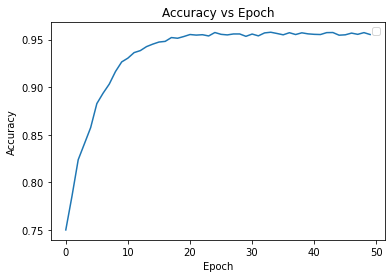

In [25]:
plt.plot( df['accuracy'])
# Set plot title and labels
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add legend
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_136496/1740024398.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  dfff['accuracy'] = dfff['accuracy'].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)', r'\1\2')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


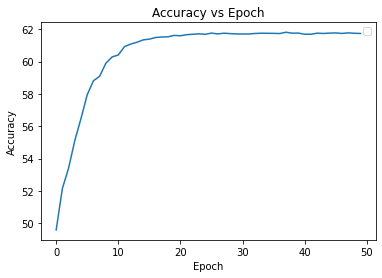

In [26]:
kfold_eval_path_val ='/home/shsingh/knowledge_distillation/kfold_result/flair/baseline/densenet121/fold0/list_val_acc_fold0.csv'
kfold_eval_val_acc  = pd.read_csv(kfold_eval_path_val)

df_val = kfold_eval_val_acc.copy()
dfff = pd.DataFrame(df_val.T)
dfff.reset_index(level=0, inplace=True)
# Rename the column
dfff = dfff.rename(columns={'index': 'accuracy'})
# Convert the 'accuracy' column to numeric type
dfff['accuracy'] = dfff['accuracy'].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)', r'\1\2')
dfff['accuracy'] = pd.to_numeric(dfff['accuracy'], errors='coerce')
# Round the 'accuracy' column to 4 decimal places
dfff['accuracy'] = dfff['accuracy'].round(4)
dfff = dfff.rename_axis('epoch')


plt.plot( dfff['accuracy'])
# Set plot title and labels
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add legend
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_136496/2018388527.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  fold0_loss_df['loss'] = fold0_loss_df['loss'].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)', r'\1\2')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


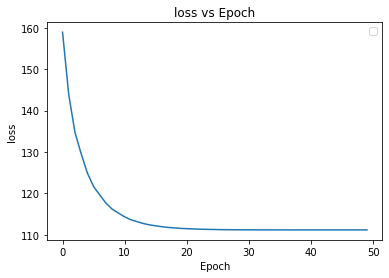

In [34]:
fold0_loss_path ='/home/shsingh/knowledge_distillation/kfold_result/flair/baseline/efficientnet_v2_s/fold0/list_train_loss_fold0.csv'
fold0_loss_df  = pd.read_csv(fold0_loss_path)

# df_val = fold0_loss_df.copy()
fold0_loss_df = pd.DataFrame(fold0_loss_df.T)
fold0_loss_df.reset_index(level=0, inplace=True)
# Rename the column
fold0_loss_df = fold0_loss_df.rename(columns={'index': 'loss'})
# Convert the 'accuracy' column to numeric type
fold0_loss_df['loss'] = fold0_loss_df['loss'].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)', r'\1\2')
fold0_loss_df['loss'] = pd.to_numeric(fold0_loss_df['loss'], errors='coerce')
# Round the 'accuracy' column to 4 decimal places
fold0_loss_df['loss'] = fold0_loss_df['loss'].round(4)
fold0_loss_df = fold0_loss_df.rename_axis('epoch')


plt.plot( fold0_loss_df['loss'])
# Set plot title and labels
plt.title('loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('loss')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [35]:
kfold_result = Path('/home/shsingh/knowledge_distillation/kfold_result')
mod = 'flair'
model_type = 'baseline'
model_name = 'densenet121'
fold = 'fold0'
metric = 'acc' #f1, loss

In [44]:
def get_metric_plotting_df(df_metric, metric):    
    df = pd.DataFrame(df_metric.T)
    df.reset_index(level=0, inplace=True)
    
    metric_col_name =  metric
        
    # Rename the column
    df = df.rename(columns={'index': metric_col_name})
    # Convert the 'accuracy' column to numeric type
    df[metric_col_name] = df[metric_col_name].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)', r'\1\2')
    df[metric_col_name] = pd.to_numeric(df[metric_col_name], errors='coerce')
    # Round the 'accuracy' column to 4 decimal places
    df[metric_col_name] = df[metric_col_name].round(4)
        
    df = df.rename_axis('epoch')
    return df

In [79]:
def get_and_save_trainig_plots(mod, model_type, model_name, fold, metric ):
    
    kfold_result = Path('/home/shsingh/knowledge_distillation/kfold_result')
    fold_path =  kfold_result/ mod / model_type / model_name / fold 
    
    train_csv_path =  fold_path / f'list_train_{metric}_{fold}.csv'
    val_csv_path = fold_path / f'list_val_{metric}_{fold}.csv'
    
    train_df = pd.read_csv(train_csv_path)
    val_df = pd.read_csv(val_csv_path)

    
    if metric == 'acc':   
        metric = 'accuracy'
    else:
        metric = metric
        
    
    
    train_df_plot = get_metric_plotting_df(train_df, metric)
    val_df_plot = get_metric_plotting_df(val_df, metric)
    
    train_df_plot[metric] = train_df_plot[metric] / 10
#     val_df_plot[metric] = val_df_plot[metric] / 100
    
    plt.plot(train_df_plot[metric], label='train')
    plt.plot(val_df_plot[metric], label='validation')

    # Set plot title and labels
    plt.title(f'{metric} vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    # Add legend
    plt.legend(['train', 'val'],loc='best')
    # Show the plot
    plt.show()
    return  train_df_plot, val_df_plot  

/tmp/ipykernel_136496/273268008.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df[metric_col_name] = df[metric_col_name].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)', r'\1\2')
/tmp/ipykernel_136496/273268008.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df[metric_col_name] = df[metric_col_name].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)', r'\1\2')


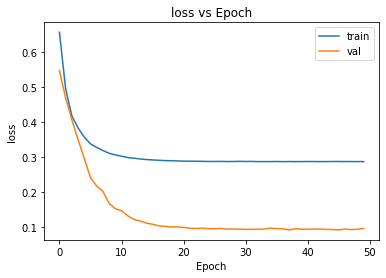

In [80]:

mod = 'flair'
model_type = 'baseline'
model_name = 'densenet121'
fold = 'fold0'
metric = 'loss' #f1, loss

train_df_plot, val_df_plot   = get_and_save_trainig_plots(mod, model_type, model_name, fold, metric )

In [49]:
train_df_plot

,accuracy
epoch,
0,0.7499
1,0.7855
2,0.8237
3,0.8405
4,0.8574
5,0.8827
6,0.8936
7,0.9032
8,0.9164


# DRAFT code

In [23]:
def create_groupKFold_splits(df,class_column_name, subject_id_column_name,  k =3):
    
    train_0 = []
    train_1 = []
    train_2 = []

    val_0 = []
    val_1 = []
    val_2 = []
    
    X = df
    y = df[class_column_name]
    
    groups = df[subject_id_column_name].values
    group_kfold = GroupKFold(n_splits=3)
    group_kfold.get_n_splits(X, y, groups)
    
    for i, (train_index, test_index) in enumerate(group_kfold.split(X, y,groups)):
        print(f"Fold {i}:")
        if i == 0:
            train_0.extend(groups[train_index])
            val_0.extend(groups[test_index])
        if i == 1:
            train_1.extend(groups[train_index])
            val_1.extend(groups[test_index])
        if i == 2:
            train_2.extend(groups[train_index])
            val_2.extend(groups[test_index])

        print(f"  Train: index={train_index}, group={groups[train_index]}")
        print(f"  Test:  index={test_index}, group={groups[test_index]}")
        
    print(any(item in np.unique(val_0) for item in np.unique(train_0)))
    print(any(item in np.unique(val_1) for item in np.unique(train_1)))
    print(any(item in np.unique(val_2) for item in np.unique(train_2)))
    return  train_0, val_0, train_1, val_1, train_2, val_2

In [24]:
train_0, val_0, train_1, val_1, train_2, val_2 = create_groupKFold_splits(train_df_indexed,
                                                                          class_column_name,
                                                                          subject_id_column_name,
                                                                          k =3)

Fold 0:
  Train: index=[    0     1     2 ... 42622 42623 42624], group=['BraTS20_Training_001' 'BraTS20_Training_001' 'BraTS20_Training_001' ...
 'BraTS20_Training_368' 'BraTS20_Training_368' 'BraTS20_Training_368']
  Test:  index=[  155   156   157 ... 42777 42778 42779], group=['BraTS20_Training_002' 'BraTS20_Training_002' 'BraTS20_Training_002' ...
 'BraTS20_Training_369' 'BraTS20_Training_369' 'BraTS20_Training_369']
Fold 1:
  Train: index=[    0     1     2 ... 42777 42778 42779], group=['BraTS20_Training_001' 'BraTS20_Training_001' 'BraTS20_Training_001' ...
 'BraTS20_Training_369' 'BraTS20_Training_369' 'BraTS20_Training_369']
  Test:  index=[  465   466   467 ... 42157 42158 42159], group=['BraTS20_Training_004' 'BraTS20_Training_004' 'BraTS20_Training_004' ...
 'BraTS20_Training_365' 'BraTS20_Training_365' 'BraTS20_Training_365']
Fold 2:
  Train: index=[  155   156   157 ... 42777 42778 42779], group=['BraTS20_Training_002' 'BraTS20_Training_002' 'BraTS20_Training_002' ...
 '

In [29]:
print(len(np.unique(train_0)), len(np.unique(val_0)) )

any(item in np.unique(val_0) for item in np.unique(train_0))

# np.unique(train_0.tolist()),np.unique(train_0.tolist())

184 92


False

In [31]:
train_df_indexed[train_df_indexed['label_flair']!='discard']

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
2,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_001,60.463,289,GTR
3,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
4,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
5,BraTS20_Training_001,BraTS20_Training_001_seg_102,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
6,BraTS20_Training_001,BraTS20_Training_001_seg_103,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_001,60.463,289,GTR
...,...,...,...,...,...,...,...,...,...,...,...
42775,BraTS20_Training_369,BraTS20_Training_369_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
42776,BraTS20_Training_369,BraTS20_Training_369_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
42777,BraTS20_Training_369,BraTS20_Training_369_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR
42778,BraTS20_Training_369,BraTS20_Training_369_seg_98,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_369,50.000,145,GTR


In [39]:
k=3
for i in range(k):
    print(i)

0
1
2


In [46]:

kfold_dict

{'train_0': [],
 'train_1': [],
 'train_2': [],
 'val_0': [],
 'val_1': [],
 'val_2': []}

In [40]:
kfold_dict = dict.fromkeys(fold_ids, [])
kfold_dict

{'fold_0': [], 'fold_1': [], 'fold_2': []}

In [50]:
kfold_dict = {f"train_{i}": [] for i in range(k)}
kfold_dict.update({f"val_{i}": [] for i in range(k)})


df = train_df_indexed.copy()

X = df
y = df[class_column_name]

groups = df[subject_id_column_name].values
group_kfold = GroupKFold(n_splits=3)
group_kfold.get_n_splits(X, y, groups)

for i, (train_index, val_index) in enumerate(group_kfold.split(X, y,groups)):
    print(f"Fold {i}:")
    kfold_dict[f'train_{i}'].extend(groups[train_index])
    kfold_dict[f'val_{i}'].extend(groups[val_index])
#     if i == 0:
#         train_0.extend(groups[train_index])
#         val_0.extend(groups[test_index])
#     if i == 1:
#         train_1.extend(groups[train_index])
#         val_1.extend(groups[test_index])
#     if i == 2:
#         train_2.extend(groups[train_index])
#         val_2.extend(groups[test_index])

    print(f"  Train: index={train_index}, group={groups[train_index]}")
    print(f"  Test:  index={val_index}, group={groups[val_index]}")

Fold 0:
  Train: index=[    0     1     2 ... 42622 42623 42624], group=['BraTS20_Training_001' 'BraTS20_Training_001' 'BraTS20_Training_001' ...
 'BraTS20_Training_368' 'BraTS20_Training_368' 'BraTS20_Training_368']
  Test:  index=[  155   156   157 ... 42777 42778 42779], group=['BraTS20_Training_002' 'BraTS20_Training_002' 'BraTS20_Training_002' ...
 'BraTS20_Training_369' 'BraTS20_Training_369' 'BraTS20_Training_369']
Fold 1:
  Train: index=[    0     1     2 ... 42777 42778 42779], group=['BraTS20_Training_001' 'BraTS20_Training_001' 'BraTS20_Training_001' ...
 'BraTS20_Training_369' 'BraTS20_Training_369' 'BraTS20_Training_369']
  Test:  index=[  465   466   467 ... 42157 42158 42159], group=['BraTS20_Training_004' 'BraTS20_Training_004' 'BraTS20_Training_004' ...
 'BraTS20_Training_365' 'BraTS20_Training_365' 'BraTS20_Training_365']
Fold 2:
  Train: index=[  155   156   157 ... 42777 42778 42779], group=['BraTS20_Training_002' 'BraTS20_Training_002' 'BraTS20_Training_002' ...
 '

In [54]:
kfold_dict
for key, value in kfold_dict.items():
    unique_values = set(value)
    print(f"Unique elements in {key}: {unique_values}")
    print('XXXXXXXXXXXXXXXXXXXXX')

Unique elements in train_0: {'BraTS20_Training_216', 'BraTS20_Training_014', 'BraTS20_Training_098', 'BraTS20_Training_208', 'BraTS20_Training_188', 'BraTS20_Training_341', 'BraTS20_Training_231', 'BraTS20_Training_349', 'BraTS20_Training_192', 'BraTS20_Training_321', 'BraTS20_Training_163', 'BraTS20_Training_131', 'BraTS20_Training_048', 'BraTS20_Training_024', 'BraTS20_Training_171', 'BraTS20_Training_186', 'BraTS20_Training_139', 'BraTS20_Training_068', 'BraTS20_Training_128', 'BraTS20_Training_028', 'BraTS20_Training_084', 'BraTS20_Training_205', 'BraTS20_Training_340', 'BraTS20_Training_054', 'BraTS20_Training_209', 'BraTS20_Training_093', 'BraTS20_Training_155', 'BraTS20_Training_065', 'BraTS20_Training_101', 'BraTS20_Training_267', 'BraTS20_Training_360', 'BraTS20_Training_320', 'BraTS20_Training_199', 'BraTS20_Training_343', 'BraTS20_Training_355', 'BraTS20_Training_311', 'BraTS20_Training_196', 'BraTS20_Training_089', 'BraTS20_Training_244', 'BraTS20_Training_255', 'BraTS20_Tr

In [ ]:

group_0 = []
group_1 = []
group_2 = []

group_0_val = []
group_1_val = []
group_2_val = []

X = df
y = df[class_column_name]
groups = df['subject_id'].values
group_kfold = GroupKFold(n_splits=3)
group_kfold.get_n_splits(X, y, groups)
# print(groups)
# print(group_kfold)
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y,groups)):
    print(f"Fold {i}:")
    if i == 0:
        group_0.extend(groups[train_index])
        group_0_val.extend(groups[test_index])
    if i == 1:
        group_1.extend(groups[train_index])
        group_1_val.extend(groups[test_index])
    if i == 2:
        group_2.extend(groups[train_index])
        group_2_val.extend(groups[test_index])

    print(f"  Train: index={train_index}, group={groups[train_index]}")
#     print('train_group:',np.unique() )
    print(f"  Test:  index={test_index}, group={groups[test_index]}")
#     train_data = df.iloc[train_index]
#     val_data = df.iloc[test_index]
    
    

In [ ]:
def check_if_overlappin_splits():
    print(any(item in np.unique(group_0_val) for item in np.unique(group_0)))
    print(any(item in np.unique(group_1_val) for item in np.unique(group_1)))
    print(any(item in np.unique(group_2_val) for item in np.unique(group_2))
        return

In [31]:
train_lis = np.unique(train_data['subject_id'])
test_lis = np.unique(val_data['subject_id'])

any(item in test_lis for item in train_lis)


False

In [21]:

print(any(item in np.unique(group_0_val) for item in np.unique(group_0)))
print(any(item in np.unique(group_1_val) for item in np.unique(group_1)))
print(any(item in np.unique(group_2_val) for item in np.unique(group_2)))

False
False
False


In [23]:

print(any(item in np.unique(group_0_val) for item in np.unique(group_1_val)))
print(any(item in np.unique(group_1_val) for item in np.unique(group_2_val)))
print(any(item in np.unique(group_2_val) for item in np.unique(group_0_val)))

False
False
False


In [22]:

print(any(item in np.unique(group_0_val) for item in np.unique(group_1_val)))
print(any(item in np.unique(group_1_val) for item in np.unique(group_2_val)))
print(any(item in np.unique(group_2_val) for item in np.unique(group_0_val)))

False
False
False
